In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
youtube_data = pd.read_csv("youtube_dataset.csv", index_col="video_id")

In [3]:
youtube_data.head()

,Unnamed: 0,published_at,title,channel_title,view_count,like_count,favorite_count,comment_count,duration,definition
video_id,,,,,,,,,,
uexN9gs5gvM,0,2023-05-04T19:01:39Z,Dei V x Myke Towers - Trending Remix (Official...,Dei V,14735004,117530.0,0,1076.0,00:04:33,hd
WXPfcRnz9Z8,1,2023-01-19T20:02:53Z,Trending - Dei V (Official Video),Dei V,6228419,62711.0,0,911.0,00:02:39,hd
K-mV_8aeQsk,2,2023-06-23T14:00:15Z,Most Unbelievable Moments Ever Caught On Camera !,Novella,7501791,38685.0,0,1138.0,00:11:04,hd
hplD4QyV4Q8,3,2019-02-24T03:00:05Z,Squash - Trending (Official Video),SquashVEVO,15445316,100024.0,0,2370.0,00:03:06,hd
XqHLbmM6Iew,4,2023-11-23T12:35:32Z,TRENDING રીધમ || ROHIT THAKOR || rohit thakor ...,SK OFFICIAL PUNAJ,1049158,14913.0,0,136.0,00:05:32,hd


### Step 1:
## Preprocessing

In [4]:
from datetime import timedelta

# Remove unnecessary columns
youtube_data.drop(['Unnamed: 0', 'favorite_count', 'definition', 'title', 'channel_title'], axis=1, inplace=True)

# Remove duplicates
youtube_data.drop_duplicates(inplace=True)

# Convert 'published_at' to datetime
youtube_data['published_at'] = pd.to_datetime(youtube_data['published_at'])

# Convert 'duration' to seconds
def duration_to_seconds(duration):
    try:
        time_parts = duration.split(':')
        return int(time_parts[0]) * 3600 + int(time_parts[1]) * 60 + int(time_parts[2])
    except:
        return None

youtube_data['duration_seconds'] = youtube_data['duration'].apply(duration_to_seconds)

# Drop the original 'duration' column
youtube_data.drop('duration', axis=1, inplace=True)

# Check for missing values
youtube_data.isnull().sum()

published_at         0
view_count           0
like_count          21
comment_count       16
duration_seconds     0
dtype: int64

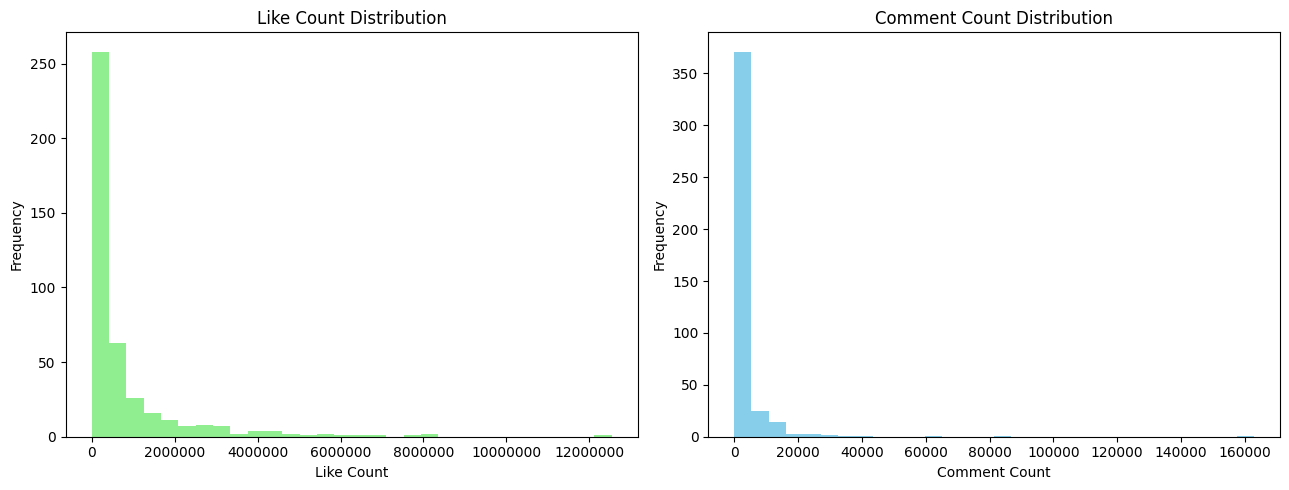

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5))

# Histogram for like_count
axs[0].hist(youtube_data['like_count'], bins=30, color='lightgreen')
axs[0].set_title('Like Count Distribution')
axs[0].set_xlabel('Like Count')
axs[0].set_ylabel('Frequency')
axs[0].ticklabel_format(style='plain', axis='x')
# axs[0].set_yscale('log')

# Histogram for comment_count
axs[1].hist(youtube_data['comment_count'], bins=30, color='skyblue')
axs[1].set_title('Comment Count Distribution')
axs[1].set_xlabel('Comment Count')
axs[1].set_ylabel('Frequency')
# axs[1].set_yscale('log')

plt.tight_layout()
plt.show()

We can detect a few outliers in the data, with a high number of comments and likes.

With that kind of distributions, filling missing values with median will be better

In [6]:
youtube_data['like_count'] = youtube_data['like_count'].fillna(youtube_data['like_count'].median())
youtube_data['comment_count'] = youtube_data['comment_count'].fillna(youtube_data['comment_count'].median())

In [7]:
# Calculate the ratio of likes per view and comments per view
youtube_data['likes_per_view'] = youtube_data['like_count'] / youtube_data['view_count']
youtube_data['comments_per_view'] = youtube_data['comment_count'] / youtube_data['view_count']

youtube_data.head()

,published_at,view_count,like_count,comment_count,duration_seconds,likes_per_view,comments_per_view
video_id,,,,,,,
uexN9gs5gvM,2023-05-04 19:01:39+00:00,14735004,117530.0,1076.0,273,0.007976,0.000073
WXPfcRnz9Z8,2023-01-19 20:02:53+00:00,6228419,62711.0,911.0,159,0.010069,0.000146
K-mV_8aeQsk,2023-06-23 14:00:15+00:00,7501791,38685.0,1138.0,664,0.005157,0.000152
hplD4QyV4Q8,2019-02-24 03:00:05+00:00,15445316,100024.0,2370.0,186,0.006476,0.000153
XqHLbmM6Iew,2023-11-23 12:35:32+00:00,1049158,14913.0,136.0,332,0.014214,0.000130


### Step 2:
## Anomaly Detection

First we'll want to visualize the data.

Since our data have more then 3 dimetions, We'll use t-SNE algorithm for 2D visualization

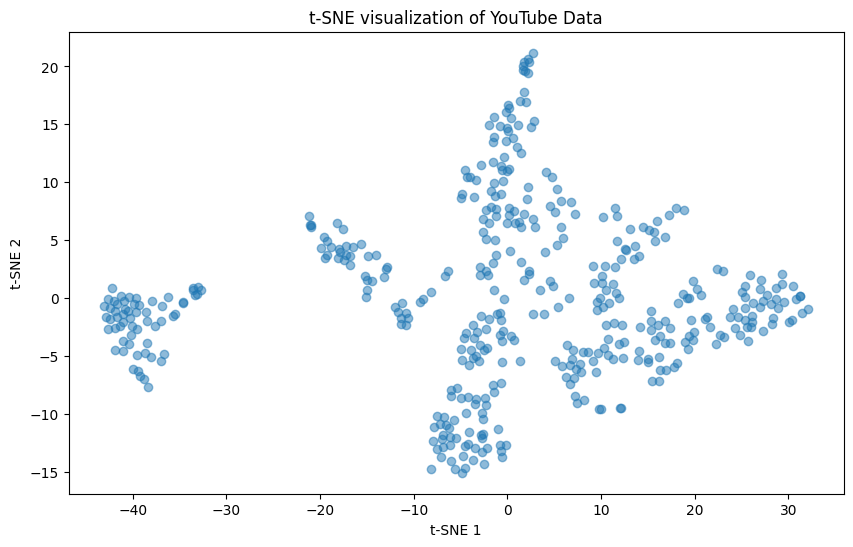

In [8]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Calculate the number of days since the first video in the dataset was published
youtube_data['days_since_published'] = (youtube_data['published_at'] - youtube_data['published_at'].min()).dt.days

# Selecting a subset of relevant numerical features for t-SNE
features = ['view_count', 'like_count', 'comment_count', 'duration_seconds', 'days_since_published']
data_subset = youtube_data[features]

# Standardizing the data (necessary for t-SNE)
scalar = StandardScaler()
data_subset_scaled = scalar.fit_transform(data_subset)

# Applying t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(data_subset_scaled)

# Plotting the results of t-SNE
plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)
plt.title('t-SNE visualization of YouTube Data')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

We can detect a cluster of samples in the left side of the plot, which is quiet different from the other samples

For Z-Score analysis, we need to assume a normal distribution for the data.

Let's perform a KS test to check whether the likes_per_view and comments_per_view follows a normal distribution 

In [9]:
from scipy.stats import kstest, norm

# Calculate mean and standard deviation for like_count and comment_count
mean_likes, std_likes = norm.fit(youtube_data['likes_per_view'])
mean_comments, std_comments = norm.fit(youtube_data['comments_per_view'])

# Perform KS Test for normality on likes_per_view and comments_per_view
ks_test_likes = kstest(youtube_data['likes_per_view'], 'norm', args=(mean_likes, std_likes))
ks_test_comments = kstest(youtube_data['comments_per_view'], 'norm', args=(mean_comments, std_comments))

# Results
ks_test_likes_result = ("KS Test for likes_per_view", ks_test_likes)
ks_test_comments_result = ("KS Test for comments_per_view", ks_test_comments)

ks_test_likes_result, ks_test_comments_result

(('KS Test for likes_per_view',
  KstestResult(statistic=0.21351814602825087, pvalue=4.818186098988027e-18, statistic_location=0.002829025809449978, statistic_sign=-1)),
 ('KS Test for comments_per_view',
  KstestResult(statistic=0.32807733810776524, pvalue=1.3804955268119942e-42, statistic_location=0.0, statistic_sign=-1)))

The very small p-values (close to zero) in both tests strongly reject the null hypothesis that the data comes from a normal distribution.

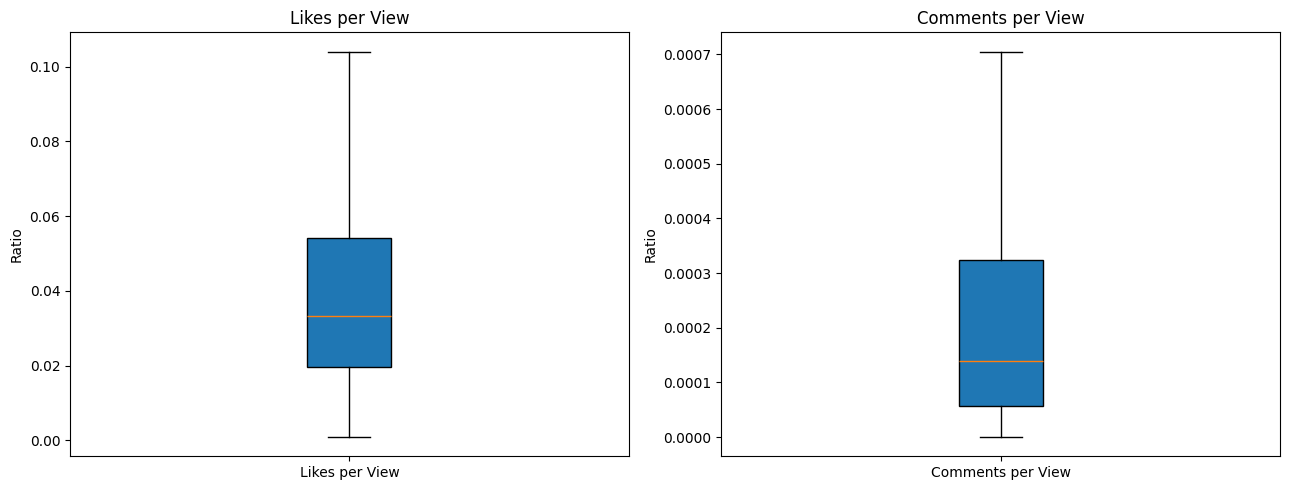

In [10]:
# Creating boxplots for likes_per_view and comments_per_view
fig, axs = plt.subplots(1, 2, figsize=(13, 5))

# Boxplot for likes_per_view
axs[0].boxplot(youtube_data['likes_per_view'], vert=True, patch_artist=True, showfliers=False)
axs[0].set_title('Likes per View')
axs[0].set_ylabel('Ratio')
axs[0].set_xticklabels(['Likes per View'])

# Boxplot for comments_per_view
axs[1].boxplot(youtube_data['comments_per_view'], vert=True, patch_artist=True, showfliers=False)
axs[1].set_title('Comments per View')
axs[1].set_ylabel('Ratio')
axs[1].set_xticklabels(['Comments per View'])

plt.tight_layout()
plt.show()

From examine the two boxplots - Likes per View and Comments per View, seems like there's no outliers in the data...

Let's try the Modified Z-Score 

In [11]:
def modified_z_score(series):
    median_series = np.median(series)
    mad_series = np.median(np.abs(series - median_series))
    if mad_series == 0:
        return series * 0  # To handle constant columns, if any
    modified_z_scores = 0.6745 * (series - median_series) / mad_series
    return modified_z_scores

# Applying the modified Z-score calculation
youtube_data['mz_likes_per_view'] = modified_z_score(youtube_data['likes_per_view'])
youtube_data['mz_comments_per_view'] = modified_z_score(youtube_data['comments_per_view'])

# Filtering for outliers using a threshold of 3.5 for the Modified Z-Score
outliers_likes_mz = youtube_data[np.abs(youtube_data['mz_likes_per_view']) > 3.5]
outliers_comments_mz = youtube_data[np.abs(youtube_data['mz_comments_per_view']) > 3.5]

# Displaying the number of outliers detected
num_outliers_likes_mz = len(outliers_likes_mz)
num_outliers_comments_mz = len(outliers_comments_mz)

print(num_outliers_likes_mz, num_outliers_comments_mz)

12 65


We got 77 outliers, Lets examine some other techniques

In [17]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope

models = {
    'LOF': LocalOutlierFactor(contamination=0.1),
    'Elliptic Envelope': EllipticEnvelope(contamination=0.1, support_fraction=1., random_state=42),
    'Isolation Forest': IsolationForest(contamination=0.1, random_state=42),
    'One-Class SVM': OneClassSVM(kernel='rbf', gamma='auto', nu=0.1)
}

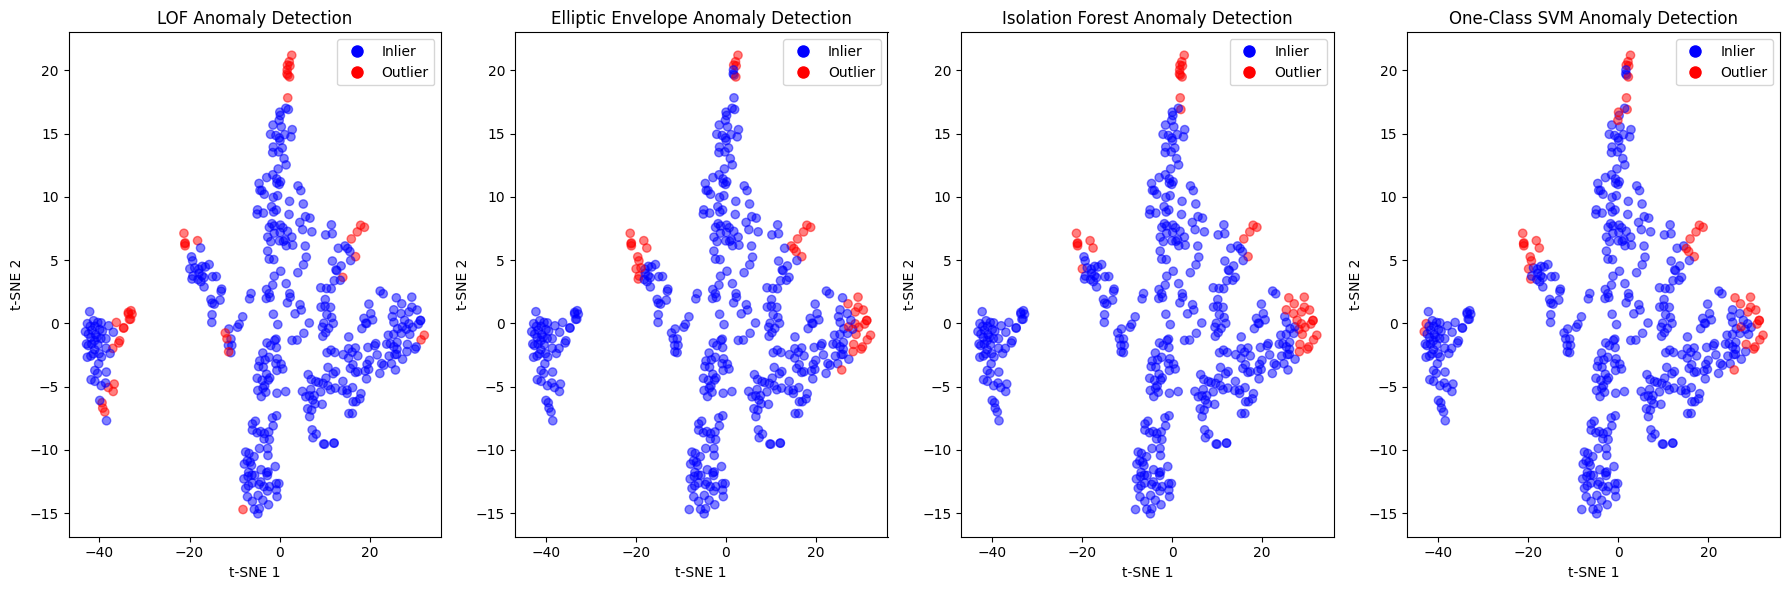

In [18]:
from matplotlib.lines import Line2D

# Setup for visualization
fig, axes = plt.subplots(1, 4, figsize=(18, 6))

# Define color map: -1 (outlier) -> red, 1 (inlier) -> blue
cmap = {1: 'blue', -1: 'red'}

for i, (name, model) in enumerate(models.items(), start=1):
    ax = axes[i-1]
    
    # For LOF, use fit_predict; for others, fit then predict
    if name in ['LOF', 'Elliptic Envelope']:
        preds = model.fit_predict(data_subset_scaled)
    else:
        model.fit(data_subset_scaled)
        preds = model.predict(data_subset_scaled)
    
    # Map prediction to colors
    colors = [cmap[p] for p in preds]
    
    # Plotting
    ax.scatter(tsne_results[:, 0], tsne_results[:, 1], c=colors, alpha=0.5)
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Inlier'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Outlier')]
    ax.legend(handles=legend_elements, loc='upper right')
    ax.set_title(f'{name} Anomaly Detection')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')

plt.tight_layout()
plt.show()

Looks like all of the models detect outliers in the areas around (0, 20), (-20, 6), and (15, 6).

This consistency across different anomaly detection algorithms suggests a high confidence in these points being genuine outliers due to their distinct characteristics from the majority of the data.

### Step 3:
## Clustering